# OCR
Optical Character Recognition의 여러 모델을 평가해 봅니다.

# 1. Google OCR API

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [13]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_img.jpg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 root root 2330 Sep 20 08:04 /aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"STOP
CUSTOMERS
ONLY
"

"STOP"

"CUSTOMERS"

"ONLY"
bounds: (434,447),(670,453),(668,518),(432,512)


# keras-OCR

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [15]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


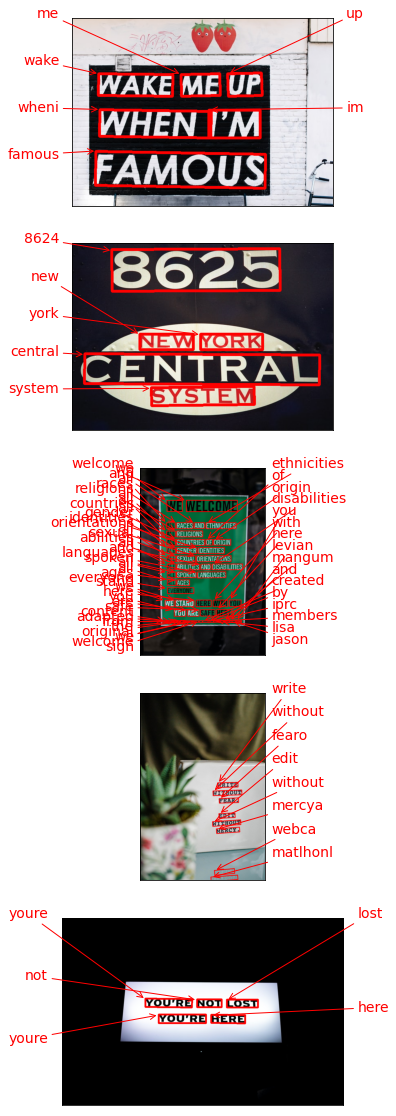

In [16]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# Tesseract OCR

In [11]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            if image.size[0]>=(left+width) and image.size[1]>=(top+height):
                cropped_image = image.crop((
                    left,
                    top,
                    left+width,
                    top+height
                ))
            try:
                cropped_image.save(output_img_path)
                cropped_image_path_list.append(output_img_path)
                index += 1
            except:
                pass
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_img.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png


In [12]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

| —_

hi

esa,

-


,

és

a

het

y

i

}\

a a ne

Done


# 4. Compare
kwansu님의 코드를 활용했습니다.

표지판의 내용을 정확히 읽어내어 auto labeling하는 서비스를 진행하려합니다. 이를 위해 가장 필요한 것은 정확도입니다. Detection의 정확도 역시 필수적입니다. 이때 간단한 task이므로 과금의 우려가 있는 GCP는 배제합니다.

### keras-ocr

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


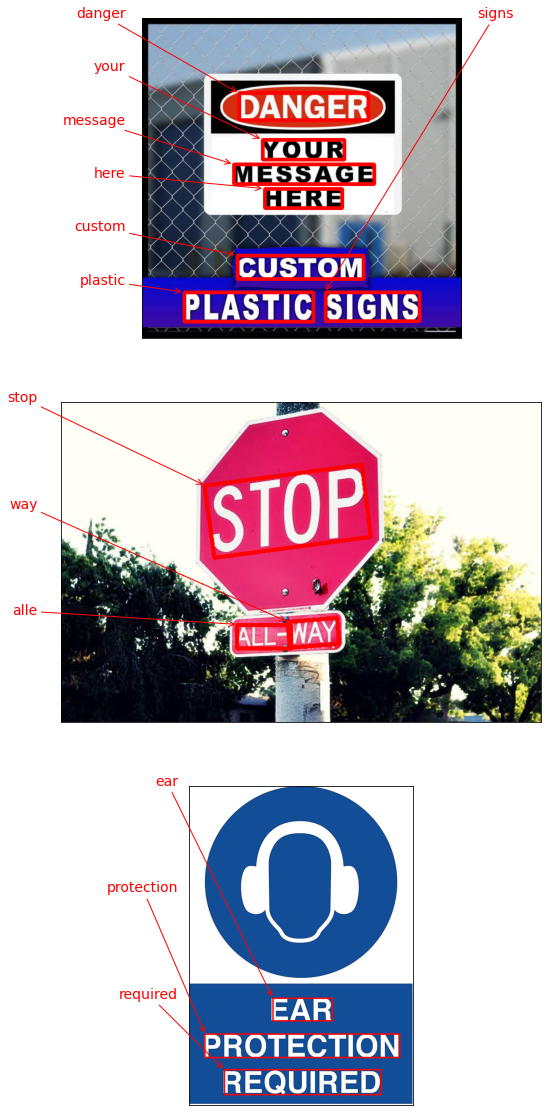

In [33]:
import glob
import keras_ocr
import matplotlib.pyplot as plt

from functools import reduce
# 상대경로를 사용했다. 환경에 맞춰 경로를 변경해야한다.
from popEval import process, make_pair, _divide


pipeline = keras_ocr.pipeline.Pipeline()

image_files = sorted(glob.glob('data/img*.jpg'))
images = [keras_ocr.tools.read(path) for path in image_files]
prediction_groups = [pipeline.recognize([path]) for path in image_files]

# keras_ocr로 부터 구한 정보를 텍스트로 저장한다.
for i, pred in enumerate(prediction_groups, start=1):
    save_path = f'data/Pred_{i:03d}.txt'
    with open(save_path, "w") as f:
        for img_info in pred:
            for line in img_info:
                for i in range(4):
                    f.write(f'{int(line[1][i][0])} {int(line[1][i][1])} ')
                f.write(f'##::{line[0]}\n')

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [34]:
def create_converted_format_file(load_path, save_path):
    ''' 수작업으로 작성한 좌표정보를 포맷에 맞게 변형하여 저장한다.
    텍스트에서 줄마다 하나의 검출된 영역과 그 영역에서의 단어를 나타낸다.
    직사각형 박스는 (x   y   w   h   word)로 기록하였다.
    사다리꼴은 (@   x1   y1   ...  x4   y4   word)이며 @로 시작한다.
    단어 사이의 띄어쓰기가 있을수 있어서 구분은 탭(\t)으로만 하였다.
    추가로 keras-ocr에서 모두 소문자로만 나와서 문자를 소문자로 변경
    하였는데, 필요하다면 특수문자나 띄어쓰기도 처리하면 좋을 듯하다.'''

    with open(load_path, "r") as f:
        lines = f.readlines()

    with open(save_path, "w") as f:
        for line in lines:
            words = line.split('\t')
            if words[0] == '@':     # 사다리꼴 검출
                line = ' '.join(words[1:9]) + f' ##::{words[-1].lower()}'
            else:                   # 직사각형 검출
                x, y, w, h = map(int, words[:4])
                line = f"{x} {y} {x+w} {y} {x+w} {y+h} {x} {y+h}##::{words[-1].lower()}"
            f.writelines(line)

for i in range(1, len(image_files)+1):
    load_path = f'data/coord_{i:03d}.txt'       # 노가다로 만든 텍스트 경로
    save_path = f'data/GT_{i:03d}.txt'          # 포맷에 맞게 저장할 경로
    create_converted_format_file(load_path, save_path)

좌표를 지정해준다
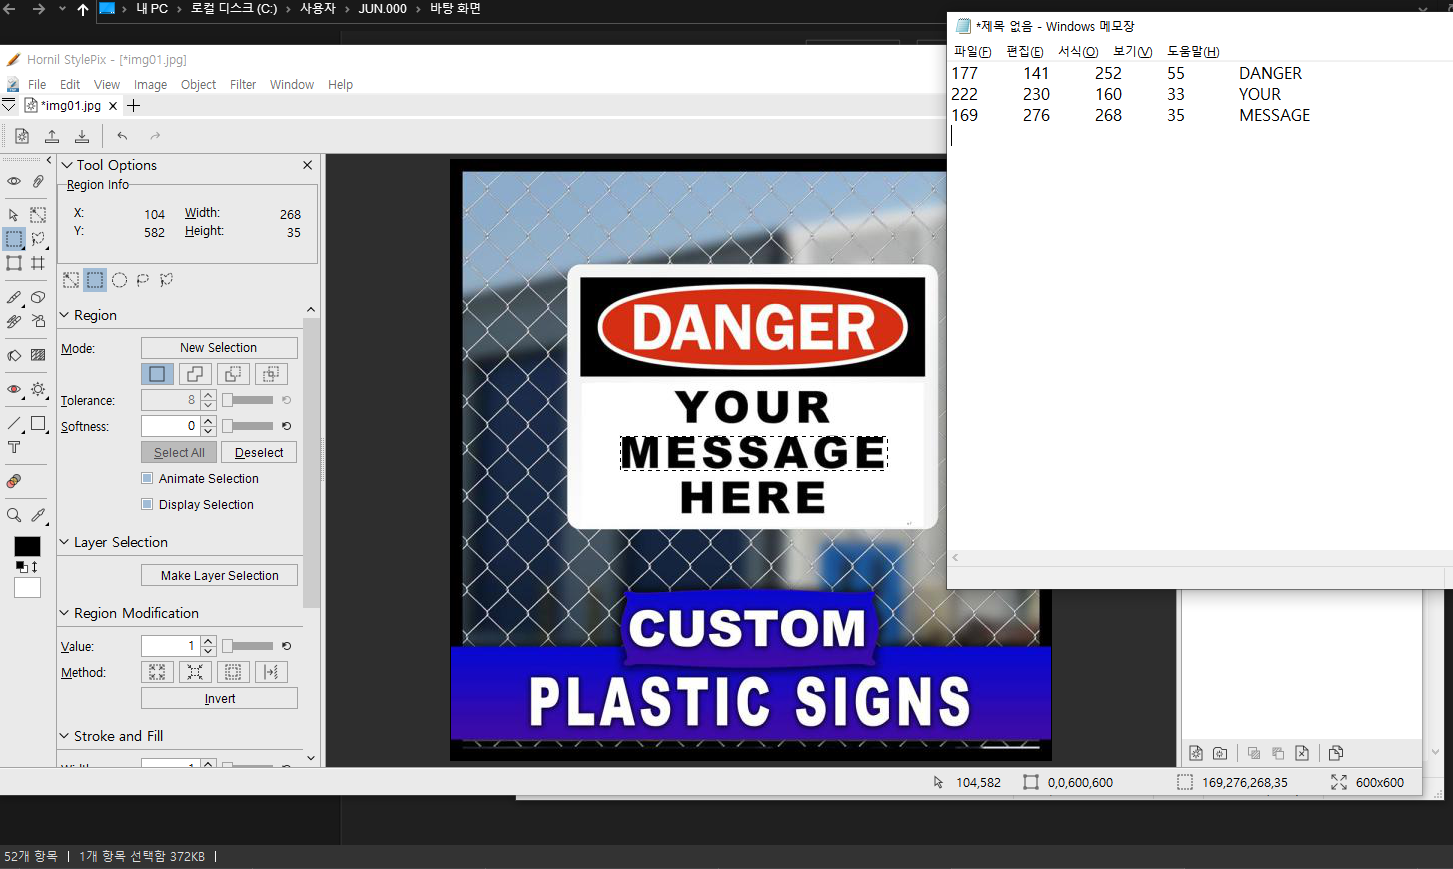

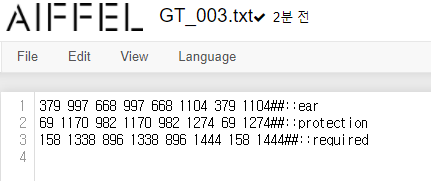

In [35]:
from functools import reduce
# 상대경로를 사용했다. 환경에 맞춰 경로를 변경해야한다.
from popEval import process, make_pair, _divide

def evaluate(gt_files, pred_files, dontcare_text='###'):
    removed_gt_char_count = 0
    precision_list = []
    recall_list = []

    total_removed_gt_char_count = 0
    total_pred_char_count = 0
    total_gt_chars_count = 0

    # 기존 멀티프로세스로 되어있던것을 변경하였다. 느리다면 기존 코드를 참고해서 변경할것.
    for result in map(process, gt_files, pred_files, [dontcare_text]*len(pred_files)):
        try:
            precision, recall, removed_gt_char_count, pred_char_count, gt_char_count = result
            total_removed_gt_char_count += removed_gt_char_count
            total_pred_char_count += pred_char_count
            total_gt_chars_count += gt_char_count
            precision_list.append(precision)
            recall_list.append(recall)
        except Exception as e:
            print(e)

    precision_for_char = _divide(
        float(total_removed_gt_char_count), float(total_pred_char_count))
    recall_for_char = _divide(
        float(total_removed_gt_char_count), float(total_gt_chars_count))
    #precision_avr = _divide(reduce(lambda x, y: x + y, precision_list, 0), len(precision_list))
    #recall_avr = _divide(reduce(lambda x, y: x + y, recall_list, 0), len(recall_list))
    perf = _divide(2*(precision_for_char*recall_for_char),
                   (precision_for_char + recall_for_char))

    print(' num | precision |  recall  |')
    for i, (precision, recall) in enumerate(zip(precision_list, recall_list), start=1):
        print(f' {i:03d} | {precision:f}  | {recall:f} |')
    print("======================")
    return precision_for_char, recall_for_char, perf


GT_files = sorted(glob.glob('data/GT_*.txt'))
D_files = sorted(glob.glob('data/Pred_*.txt'))

if len(GT_files) != len(D_files):
    print("Caution: GT_files' len(%d) and D_files' len(%d) are different."%(len(GT_files), len(D_files)))
    GT_files, D_files = make_pair(GT_files, D_files)
    print("We will evaluate on %d files"%(len(GT_files)))

pr, re, pref = evaluate(GT_files, D_files)
print("precision, recall, H:")
print("%0.1f, %0.1f, %0.1f"%(100.*pr, 100.*re, 100.*pref))

 num | precision |  recall  |
 001 | 1.000000  | 1.000000 |
 002 | 0.909091  | 0.909091 |
 003 | 1.000000  | 1.000000 |
precision, recall, H:
98.6, 98.6, 98.6


### Tesseract ocr

In [38]:
work_dir = os.getenv('HOME')+'/aiffel/000Projects/data'
img_file_path = work_dir + '/img01.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/000Projects/data/0000.png
/aiffel/aiffel/000Projects/data/0001.png


In [39]:
recognize_images(cropped_image_path_list)



Done


In [40]:
img_file_path = work_dir + '/img02.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/000Projects/data/0000.png
b < ,

Done


In [41]:
img_file_path = work_dir + '/img03.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/000Projects/data/0000.png
/aiffel/aiffel/000Projects/data/0001.png
/aiffel/aiffel/000Projects/data/0002.png
/aiffel/aiffel/000Projects/data/0003.png
/aiffel/aiffel/000Projects/data/0004.png
/aiffel/aiffel/000Projects/data/0005.png
/aiffel/aiffel/000Projects/data/0006.png
/aiffel/aiffel/000Projects/data/0007.png

|

|

—y Ayn,

PROTECTION

REQUIRED

TION


Done


Detection과 글자 분류 모두 keras-ocr이 훨씬 훌륭한 성능을 냈습니다. Tesseract의 경우 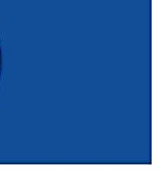처럼 문자가 없는 영역을 ROI에 포함시키기도 하였습니다.

# 회고

1️⃣ 잘한 점:

Tesseract와 keras-ocr을 잘 비교했다.

popEval이라는 라이브러리를 통해 같은 영역에 있는 문자를 비교했다

2️⃣ 어려웠던 점:

Ground Truth label을 만들기 위해 직접 문자가 존재하는 영역의 좌표를 찍어서 coord 파일을 만드는 것

3️⃣ 느낀 점:

OCR도 task마다 강점인 라이브러리가 다른 것 같다. 한 쪽에서는 잘 안 되지만 아직 시도하지 않은 쪽에서는 잘 될 수 있다는 가능성을 염두에 두어야 하겠다.